In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style(style='dark')
plt.rcParams['figure.dpi'] = 200

import warnings
warnings.filterwarnings("ignore")

import cv2
import tensorflow as tf

from tqdm.auto import tqdm
import shutil

import imgaug.augmenters as iaa
import uuid

seed = 42
np.random.seed(seed=seed)

In [ ]:
! mkdir -p /root/.kaggle
! mv kaggle.json /root/.kaggle
import kaggle

In [ ]:
!kaggle competitions download -c dog-breed-identification

 99% 682M/691M [00:04<00:00, 194MB/s]
100% 691M/691M [00:04<00:00, 166MB/s]


In [ ]:
!unzip -q /content/dog-breed-identification.zip

In [ ]:
df = pd.read_csv('labels.csv')

In [ ]:
def get_fname(id):
  fname = id+'.jpg'
  return fname

df['fname'] = df['id'].apply(get_fname)
df.drop(columns='id', inplace=True)
df.head()

,breed,fname
0,boston_bull,000bec180eb18c7604dcecc8fe0dba07.jpg
1,dingo,001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,pekinese,001cdf01b096e06d78e9e5112d419397.jpg
3,bluetick,00214f311d5d2247d5dfe4fe24b2303d.jpg
4,golden_retriever,0021f9ceb3235effd7fcde7f7538ed62.jpg


## Utility Functions

In [ ]:
def get_model(architecture, add_conv=False, n_conv=1):

  for layer in architecture.layers:
    layer.trainable = False

  if add_conv==True:

    input = architecture.output
    for cnv in range(n_conv):
      conv = tf.keras.layers.Conv2D(kernel_size=(3,3), filters=512, activation='relu', padding="same")(input)
      input = conv
    max_pool = tf.keras.layers.MaxPool2D()(conv)
    flat = tf.keras.layers.Flatten() (max_pool)

  else:
    flat = tf.keras.layers.Flatten() (architecture.output)

  dense1 = tf.keras.layers.Dense(1024, activation='relu') (flat)
  dense2 = tf.keras.layers.Dense(512, activation='relu') (dense1)
  output = tf.keras.layers.Dense(120, activation="softmax") (dense2)

  model = tf.keras.models.Model(inputs=[architecture.input], outputs=[output])

  model.compile(optimizer=tf.keras.optimizers.SGD(),
                      loss=tf.keras.losses.categorical_crossentropy,
                      metrics=["acc"])

  return model

In [ ]:
def get_plots(history, model_name):
  acc = history.history['acc']
  val_acc = history.history['val_acc']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.subplots(1, 2, figsize=(10, 5))
  plt.subplot(121)
  plt.plot(acc, label='acc', color = 'maroon')
  plt.plot(val_acc, label = 'val_acc', color='teal')
  plt.title('Accuracy vs Epoch')
  plt.legend()

  plt.subplot(122)
  plt.plot(loss, label='loss', color = 'maroon')
  plt.plot(val_loss, label = 'val_loss', color='teal')
  plt.ylim((0,10))
  plt.title('Loss vs Epoch')

  plt.suptitle(model_name, weight='black', color='green', fontsize=18)
  plt.legend()
  plt.show()

In [ ]:
def get_augumented(source_paths, n_copies, dest_path, breed):

  ##Load Data
  images = []
  for path in source_paths:
    img = cv2.imread(path)
    images.append(img)

  #Augmentation
  seq = iaa.Sequential([
                          #fliping the image
                          iaa.Fliplr(0.5),
                          iaa.Flipud(0.5),

                          # Small gaussian blur with random sigma between 0 and 0.5.
                          iaa.Sometimes(0.5,
                                        iaa.GaussianBlur(sigma=(0, 0.5))),

                          # Strengthen or weaken the contrast in each image.
                          iaa.LinearContrast((0.75, 1.5)),

                          # Add gaussian noise.
                          iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),

                          # Make some images brighter and some darker.
                          iaa.Multiply((0.8, 1.2), per_channel=0.2),

                          # Apply affine transformations to each image.
                          iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                                    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                                    rotate=(-25, 25),
                                    shear=(-8, 8))
                      ], random_order=True)

  augmented_images = []
  print('=='*70)
  print('Augumenting images...')
  for i in tqdm(range(n_copies)):
    augmented_image = seq(images=images)
    augmented_images.extend(augmented_image)

  #Saving
  print('=='*70)
  print('Saving augumented images...')
  aug_df = pd.DataFrame(columns = ['breed', 'fname'])
  for i, img in tqdm(enumerate(augmented_images)):

    hex = str(uuid.uuid4().hex)
    fname = hex+'.jpg'
    path = os.path.join(dest_path, fname)
    cv2.imwrite(path, img)

    aug_df.loc[i, 'breed'] = breed
    aug_df.loc[i, 'fname'] = fname

  return aug_df

In [ ]:
def get_indices(train_idg, breed):

  idx = train_idg.class_indices[breed]
  return idx

## Data Augumentation

In [ ]:
os.mkdir('aug_data')

In [ ]:
aug_df = pd.DataFrame(columns = ['breed', 'fname'])
breeds = df['breed'].unique()
for breed in breeds:

  filtered_df = df.loc[df['breed']==breed]
  qty = (filtered_df.shape[0])
  fnames = filtered_df['fname'].values

  source_paths = 'train/' + fnames
  n_copies =  int(250/qty)
  dest_path = 'aug_data'

  breed_df = get_augumented(source_paths, n_copies, dest_path, breed)
  aug_df = pd.concat([aug_df, breed_df], axis=0)

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/1 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/2 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

Augumenting images...


  0%|          | 0/3 [00:00<?, ?it/s]

Saving augumented images...


0it [00:00, ?it/s]

In [ ]:
len(os.listdir('aug_data'))

25397

In [ ]:
aug_df.head()

,breed,fname
0,boston_bull,ed3e5b6a65f440019e73794d5b729dee.jpg
1,boston_bull,8cd77f5a1f284d83bbd7c82f50224784.jpg
2,boston_bull,34a38c2f3394419bb2615beac5c51e8d.jpg
3,boston_bull,ce65f81fad8d49ec8306562b7fcae09b.jpg
4,boston_bull,75443a33012f40089669592eecce437e.jpg


In [ ]:
os.mkdir('train_aug')

In [ ]:
breeds = df['breed'].unique()
for breed in tqdm(breeds):

  qty = df.loc[df['breed']==breed].shape[0]
  aug_filtered_df = aug_df.loc[aug_df['breed']==breed]
  aug_fnames = aug_filtered_df['fname'].values

  mv_qty = 200-qty

  for i in range(mv_qty):
    source_path = os.path.join('aug_data',aug_fnames[i])
    dest_path = os.path.join('train_aug', aug_fnames[i])
    shutil.copy(source_path, dest_path)

  0%|          | 0/120 [00:00<?, ?it/s]

In [ ]:
train_aug_df = pd.DataFrame(columns=['breed', 'fname'])
breeds = aug_df['breed'].unique()
for breed in tqdm(breeds):

  qty = df.loc[df['breed']==breed].shape[0]
  idx = 200-qty
  filtered_df = aug_df.loc[aug_df['breed']==breed]
  temp_df = filtered_df[:idx]

  train_aug_df = pd.concat([train_aug_df, temp_df], axis=0)

  0%|          | 0/120 [00:00<?, ?it/s]

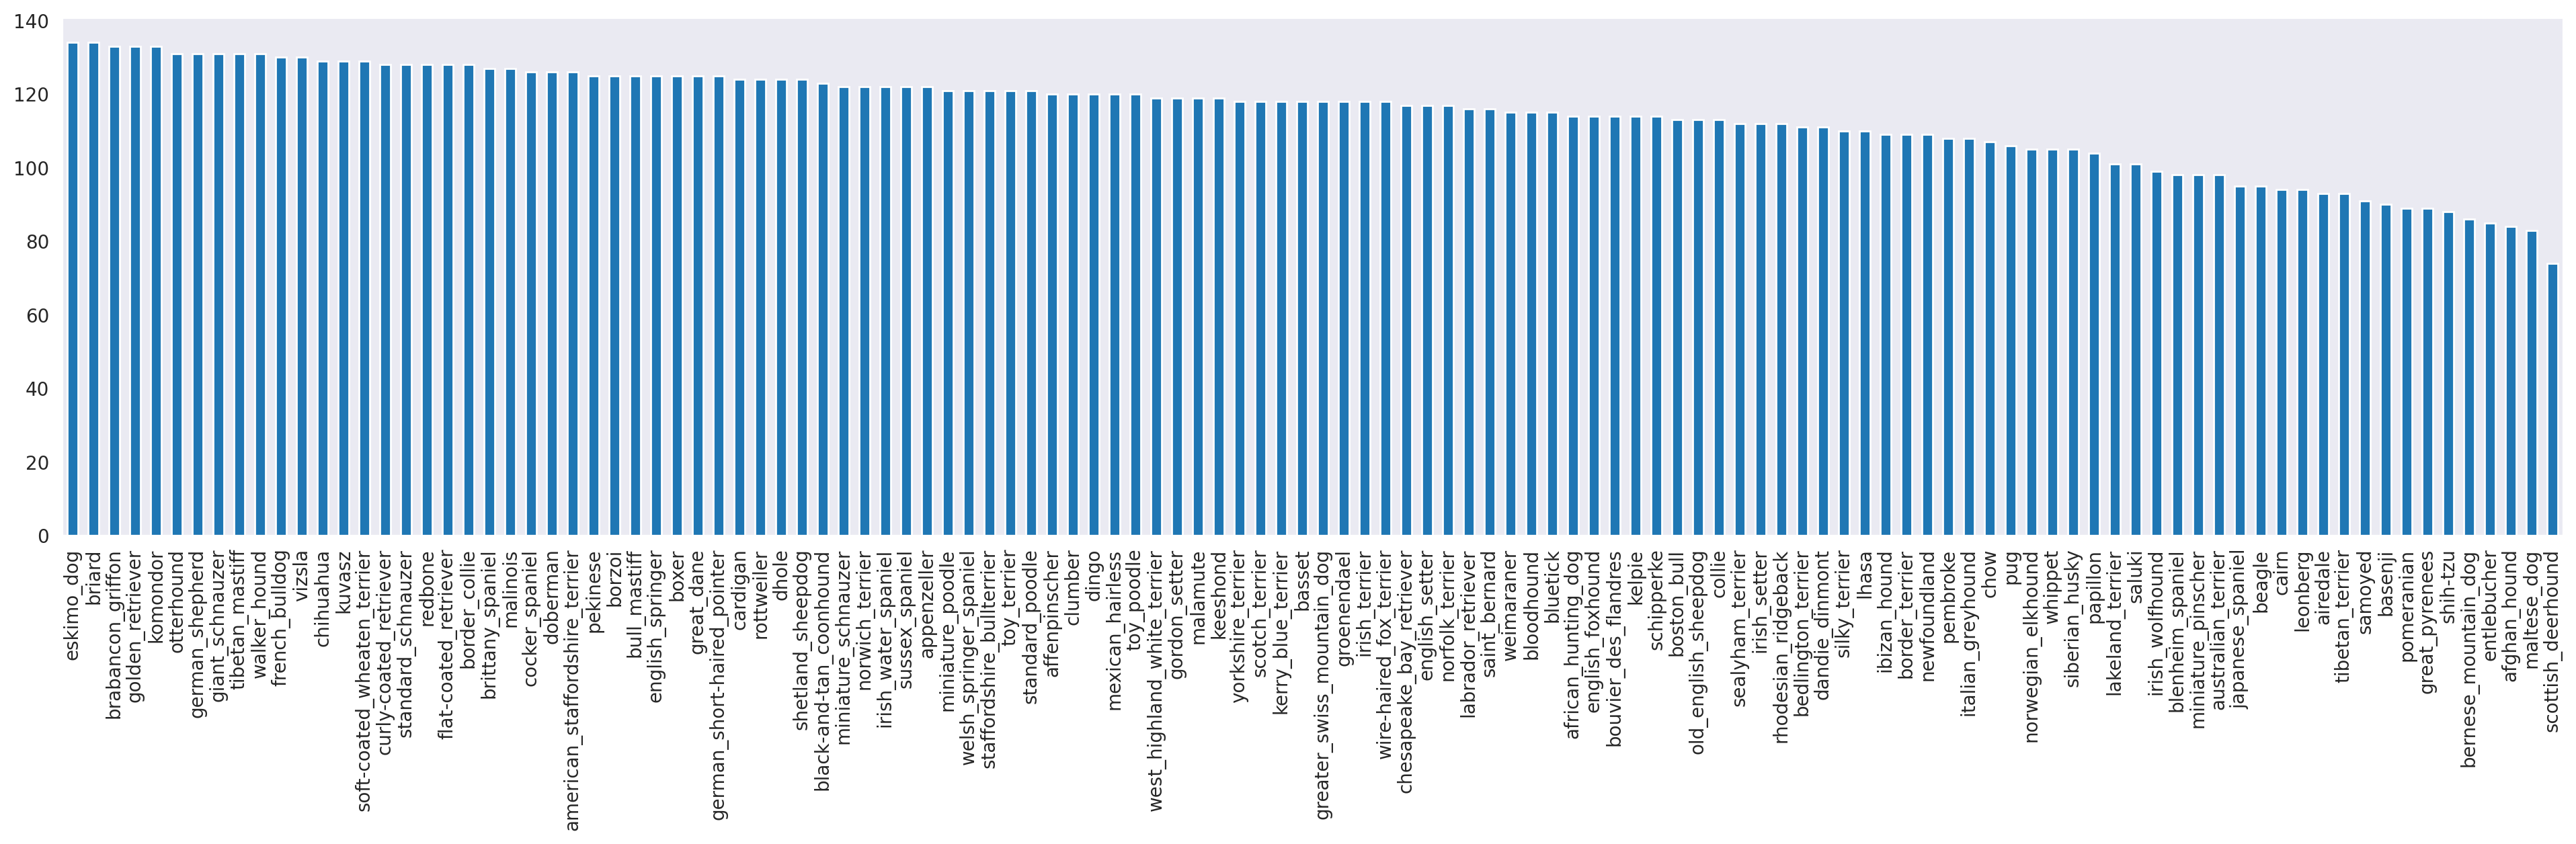

In [ ]:
plt.figure(figsize=(24,5))
train_aug_df.breed.value_counts().plot.bar()
plt.show()

In [ ]:
fnames = df['fname'].values
for fname in tqdm(fnames):

  source_path = os.path.join('train', fname)
  dest_path = os.path.join('train_aug', fname)

  shutil.copy(source_path, dest_path)

  0%|          | 0/10222 [00:00<?, ?it/s]

In [ ]:
train_df = pd.concat([df, train_aug_df], axis=0)

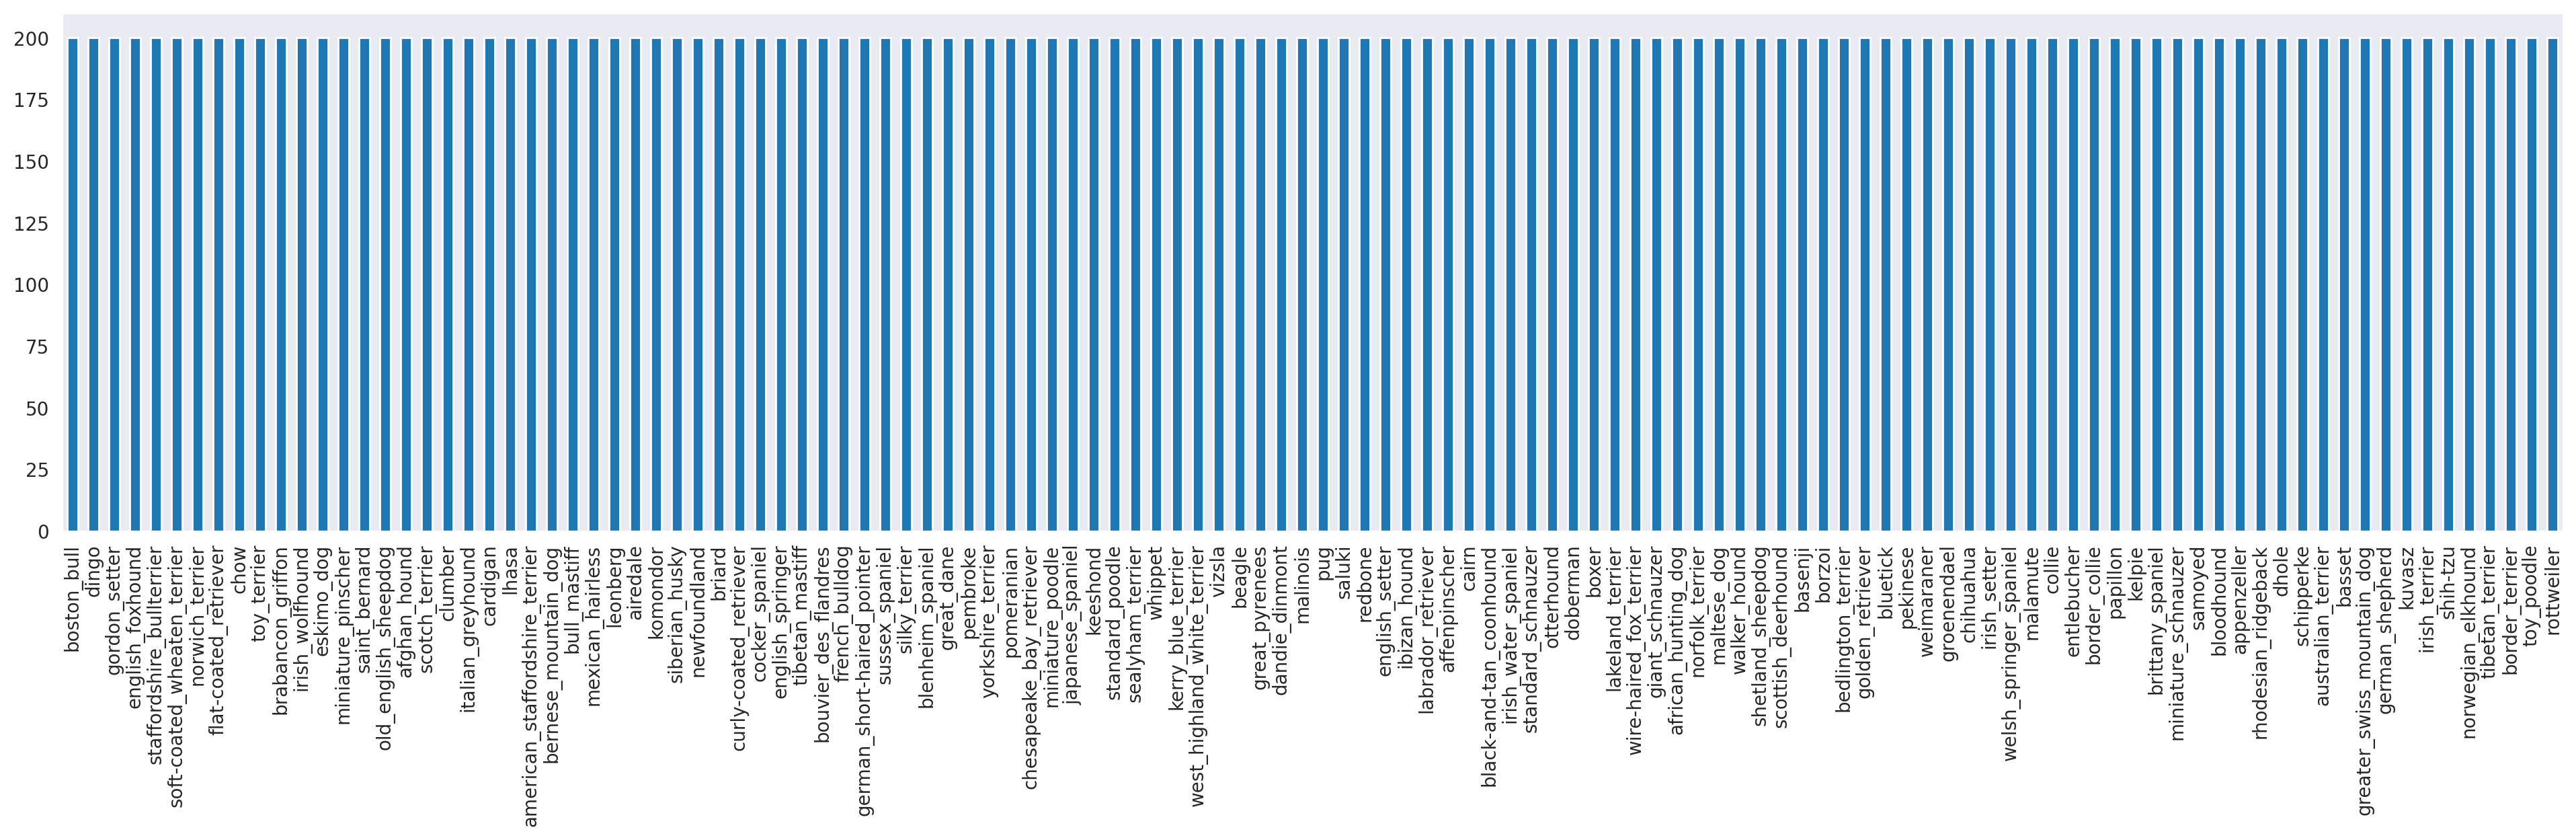

In [ ]:
plt.figure(figsize=(24,5))
train_df.breed.value_counts().plot.bar()
plt.show()

In [ ]:
train_df.to_csv('aug_labels.csv', header=True, index=False)

## VGG-19

In [ ]:
train_df.head()

,breed,fname
0,boston_bull,000bec180eb18c7604dcecc8fe0dba07.jpg
1,dingo,001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,pekinese,001cdf01b096e06d78e9e5112d419397.jpg
3,bluetick,00214f311d5d2247d5dfe4fe24b2303d.jpg
4,golden_retriever,0021f9ceb3235effd7fcde7f7538ed62.jpg


In [ ]:
batch_size = 64
target_size = (224,224)

idg = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
                                                      validation_split = 0.1)

train_idg = idg.flow_from_dataframe(train_df, directory="train_aug/", x_col="fname", y_col="breed",
                                    target_size=target_size, batch_size=batch_size,
                                    subset='training')

val_idg = idg.flow_from_dataframe(train_df, directory="train_aug/", x_col="fname", y_col="breed",
                                    target_size=target_size, batch_size=batch_size,
                                    subset='validation')

Found 21600 validated image filenames belonging to 120 classes.
Found 2400 validated image filenames belonging to 120 classes.


Epoch 1/35
338/338 [==============================] - 141s 412ms/step - loss: 8.6794 - acc: 0.0182 - val_loss: 4.7008 - val_acc: 0.0208
Epoch 2/35
338/338 [==============================] - 126s 372ms/step - loss: 4.8059 - acc: 0.0274 - val_loss: 4.5532 - val_acc: 0.0429
Epoch 3/35
338/338 [==============================] - 134s 396ms/step - loss: 4.5835 - acc: 0.0431 - val_loss: 4.4585 - val_acc: 0.0533
Epoch 4/35
338/338 [==============================] - 126s 373ms/step - loss: 4.4297 - acc: 0.0531 - val_loss: 4.3672 - val_acc: 0.0637
Epoch 5/35
338/338 [==============================] - 126s 372ms/step - loss: 4.2333 - acc: 0.0743 - val_loss: 4.1392 - val_acc: 0.1142
Epoch 6/35
338/338 [==============================] - 126s 372ms/step - loss: 4.0561 - acc: 0.1044 - val_loss: 3.8059 - val_acc: 0.1342
Epoch 7/35
338/338 [==============================] - 134s 397ms/step - loss: 3.7739 - acc: 0.1338 - val_loss: 3.5327 - val_acc: 0.1667
Epoch 8/35
338/338 [============================

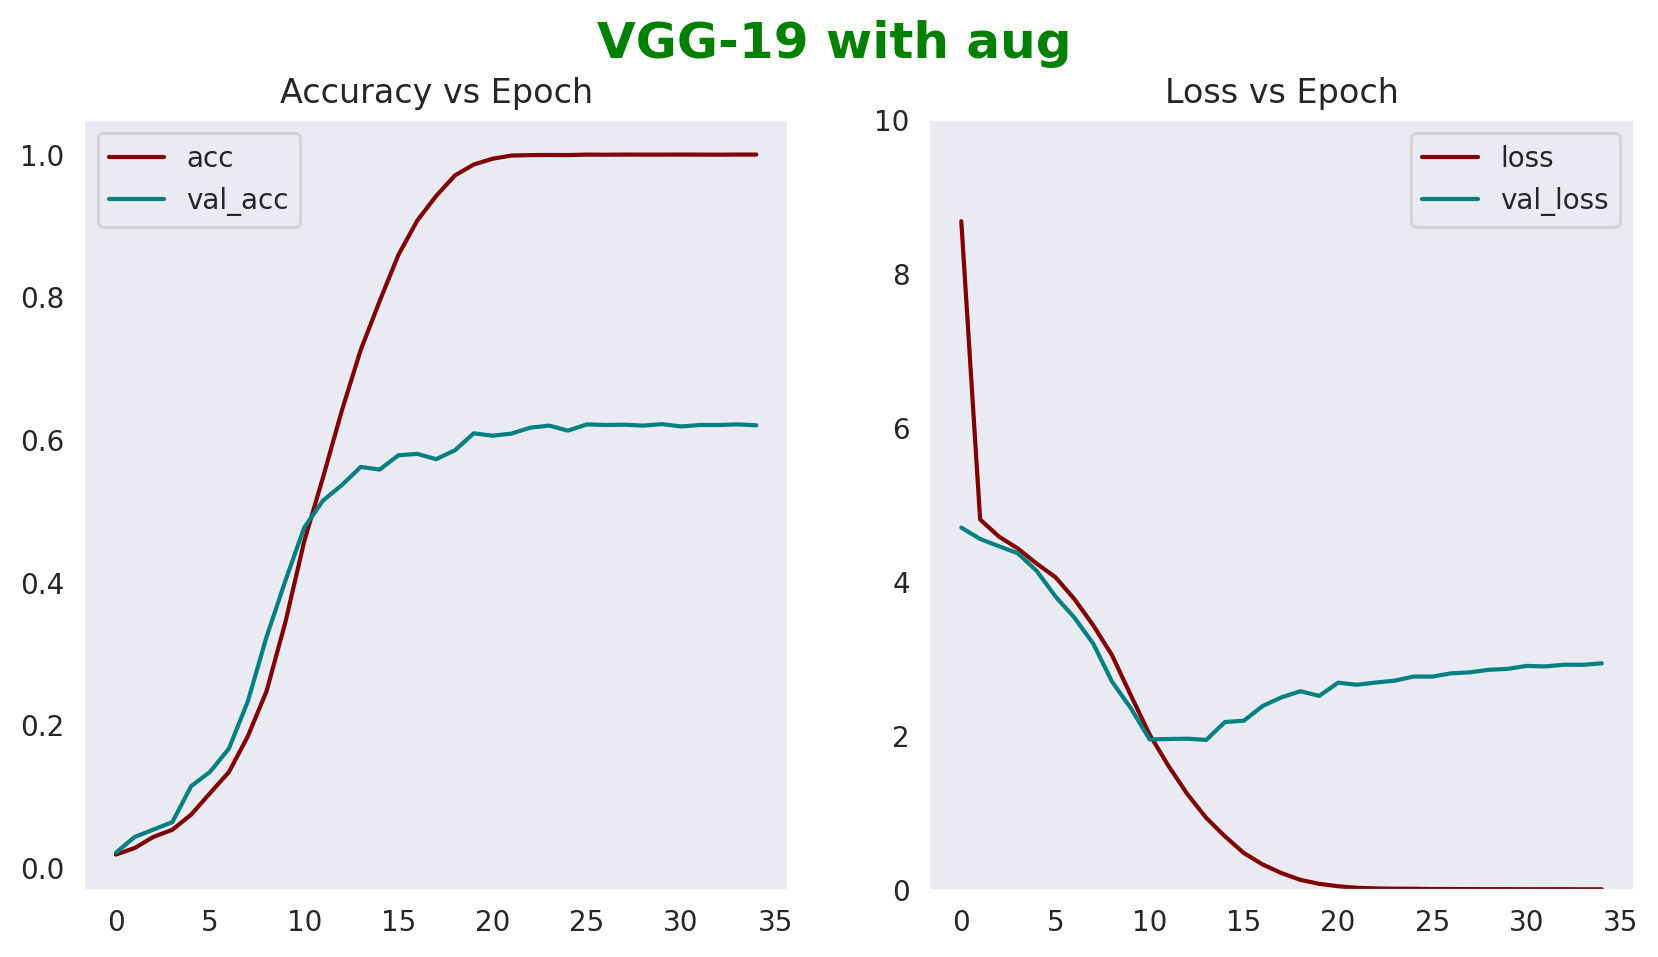

In [ ]:
vgg19 = tf.keras.applications.vgg19.VGG19(include_top=False,
                                          input_shape=(224,224, 3))

model = get_model(vgg19, add_conv=False)

vgg19_history = model.fit(train_idg,
                          batch_size = batch_size,
                          validation_data=val_idg,
                          epochs = 35)

get_plots(vgg19_history, 'VGG-19 with aug')

## VGG-19 Conv-Pool

In [ ]:
batch_size = 64
target_size = (380,380)

idg = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
                                                      validation_split = 0.1)

train_idg = idg.flow_from_dataframe(train_df, directory="train_aug/", x_col="fname", y_col="breed",
                                    target_size=target_size, batch_size=batch_size,
                                    subset='training')

val_idg = idg.flow_from_dataframe(train_df, directory="train_aug/", x_col="fname", y_col="breed",
                                    target_size=target_size, batch_size=batch_size,
                                    subset='validation')

Found 21600 validated image filenames belonging to 120 classes.
Found 2400 validated image filenames belonging to 120 classes.


Epoch 1/10
338/338 [==============================] - 404s 1s/step - loss: 5.7379 - acc: 0.0490 - val_loss: 3.3420 - val_acc: 0.1579
Epoch 2/10
338/338 [==============================] - 381s 1s/step - loss: 3.0595 - acc: 0.2256 - val_loss: 1.9325 - val_acc: 0.4683
Epoch 3/10
338/338 [==============================] - 378s 1s/step - loss: 2.0863 - acc: 0.4361 - val_loss: 1.6348 - val_acc: 0.5383
Epoch 4/10
338/338 [==============================] - 381s 1s/step - loss: 1.5103 - acc: 0.5708 - val_loss: 1.4045 - val_acc: 0.5962
Epoch 5/10
338/338 [==============================] - 377s 1s/step - loss: 1.0863 - acc: 0.6892 - val_loss: 1.3359 - val_acc: 0.6196
Epoch 6/10
338/338 [==============================] - 378s 1s/step - loss: 0.7113 - acc: 0.7950 - val_loss: 1.3723 - val_acc: 0.6454
Epoch 7/10
338/338 [==============================] - 378s 1s/step - loss: 0.4162 - acc: 0.8834 - val_loss: 1.3778 - val_acc: 0.6600
Epoch 8/10
338/338 [==============================] - 381s 1s/step - 

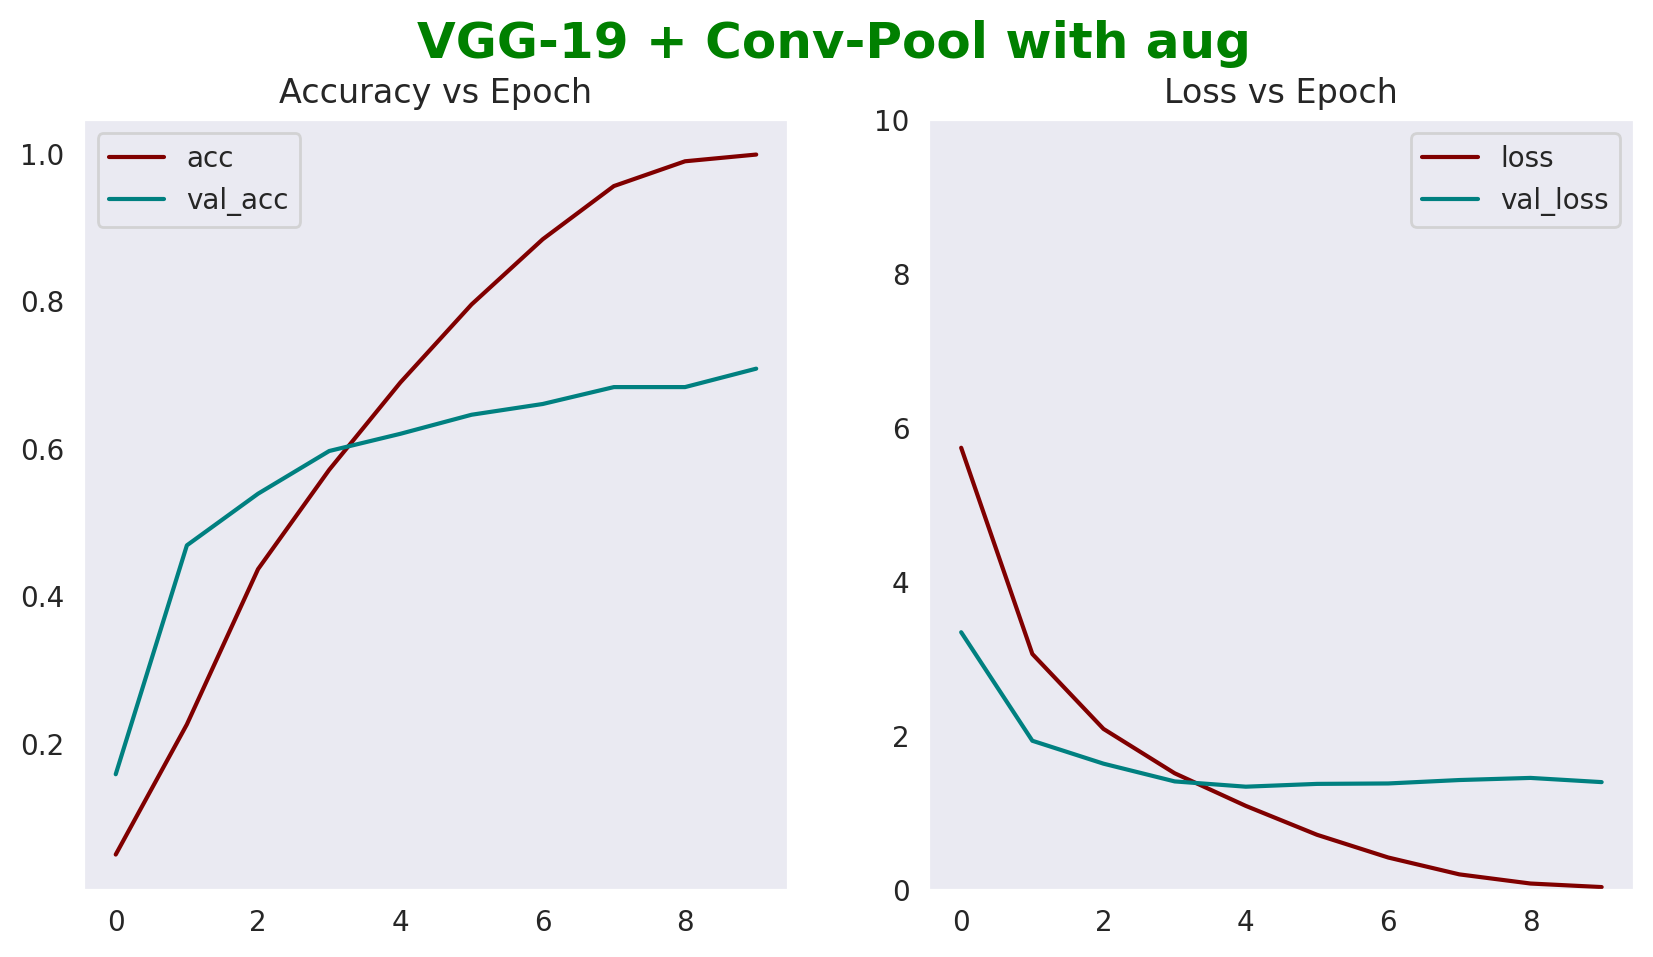

In [ ]:
vgg19 = tf.keras.applications.vgg19.VGG19(include_top=False,
                                          input_shape=(380,380, 3))

model = get_model(vgg19, add_conv=True, n_conv=1)

vgg19_conv_history = model.fit(train_idg,
                               batch_size = batch_size,
                               validation_data=val_idg,
                               epochs = 10)

get_plots(vgg19_conv_history, 'VGG-19 + Conv-Pool with aug')

## VGG-19 Conv-Conv-Pool

Epoch 1/10
338/338 [==============================] - 392s 1s/step - loss: 5.0259 - acc: 0.0860 - val_loss: 2.4008 - val_acc: 0.3217
Epoch 2/10
338/338 [==============================] - 383s 1s/step - loss: 2.3895 - acc: 0.3592 - val_loss: 1.3790 - val_acc: 0.5883
Epoch 3/10
338/338 [==============================] - 383s 1s/step - loss: 1.7417 - acc: 0.5153 - val_loss: 1.1873 - val_acc: 0.6600
Epoch 4/10
338/338 [==============================] - 383s 1s/step - loss: 1.3576 - acc: 0.6155 - val_loss: 1.0192 - val_acc: 0.6917
Epoch 5/10
338/338 [==============================] - 383s 1s/step - loss: 1.0345 - acc: 0.6974 - val_loss: 0.9775 - val_acc: 0.7138
Epoch 6/10
338/338 [==============================] - 383s 1s/step - loss: 0.7504 - acc: 0.7810 - val_loss: 1.0929 - val_acc: 0.7033
Epoch 7/10
338/338 [==============================] - 388s 1s/step - loss: 0.5279 - acc: 0.8457 - val_loss: 1.0513 - val_acc: 0.7204
Epoch 8/10
338/338 [==============================] - 394s 1s/step - 

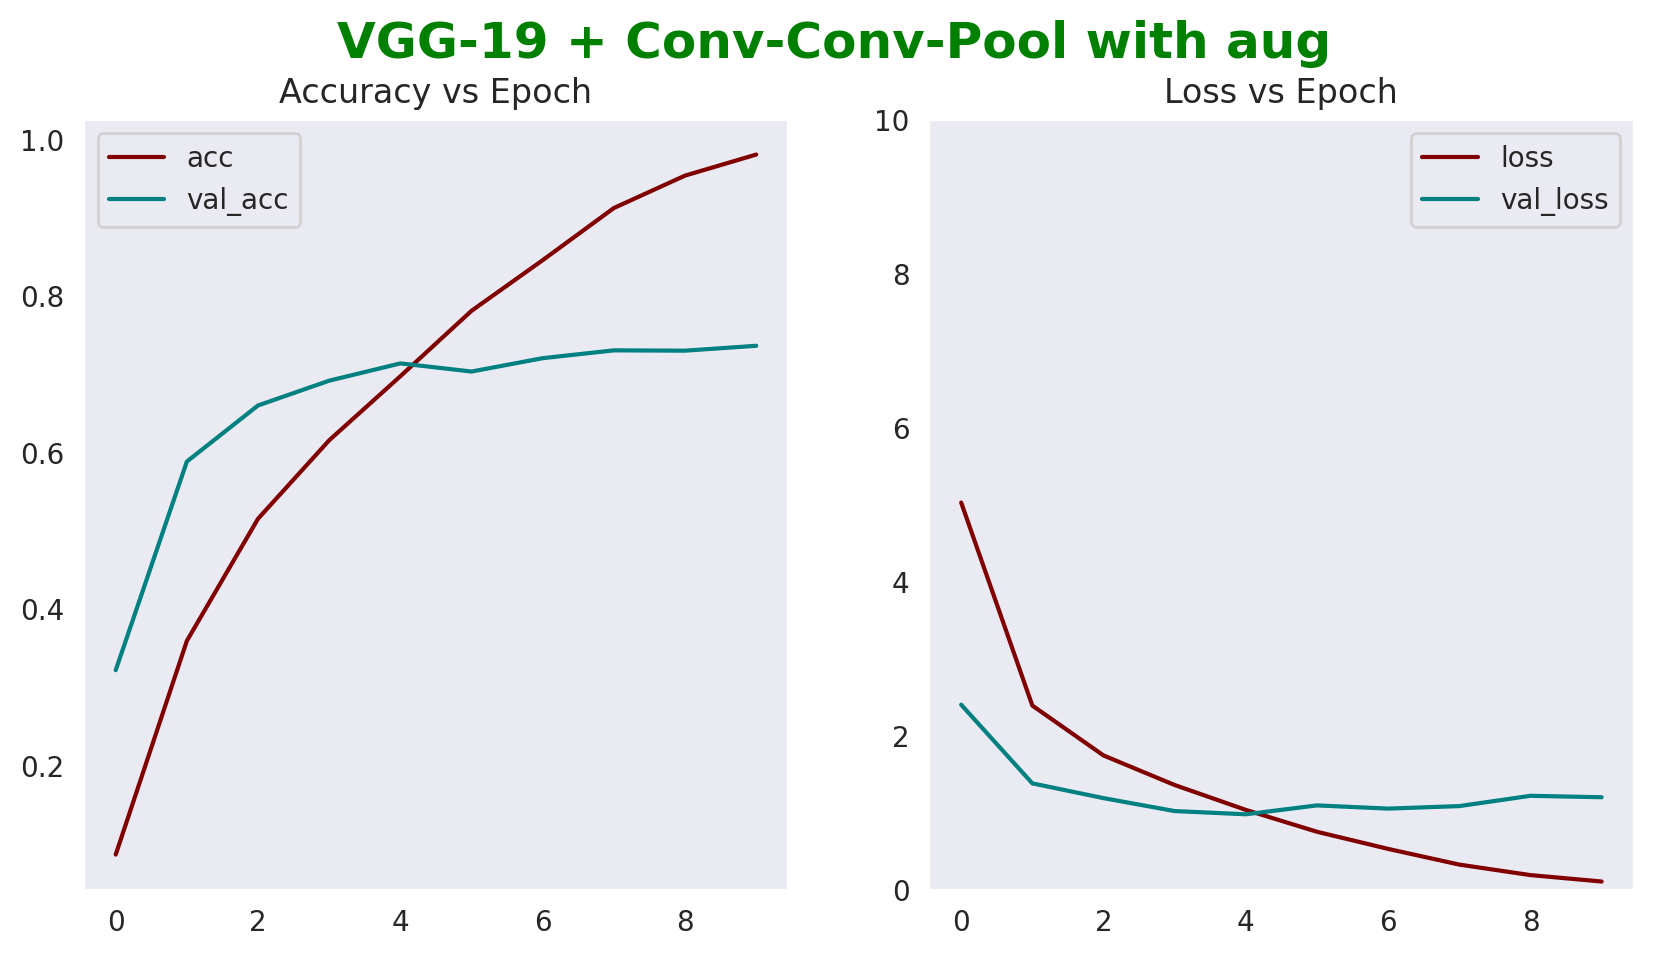

In [ ]:
vgg19 = tf.keras.applications.vgg19.VGG19(include_top=False,
                                          input_shape=(380,380, 3))

model = get_model(vgg19, add_conv=True, n_conv=2)

vgg19_conv_history = model.fit(train_idg,
                               batch_size = batch_size,
                               validation_data=val_idg,
                               epochs = 10)

get_plots(vgg19_conv_history, 'VGG-19 + Conv-Conv-Pool with aug')

## VGG-19 Conv-Conv-Conv-Pool

In [ ]:
vgg19 = tf.keras.applications.vgg19.VGG19(include_top=False,
                                          input_shape=(380,380, 3))

model = get_model(vgg19, add_conv=True, n_conv=3)

vgg19_conv_history = model.fit(train_idg,
                               batch_size = batch_size,
                               validation_data=val_idg,
                               epochs = 10)

get_plots(vgg19_conv_history, 'VGG-19 + Conv-Conv-Conv-Pool with aug')

Epoch 1/10
338/338 [==============================] - 392s 1s/step - loss: 4.5538 - acc: 0.0627 - val_loss: 2.4904 - val_acc: 0.3271
Epoch 2/10
338/338 [==============================] - 389s 1s/step - loss: 2.4839 - acc: 0.3396 - val_loss: 1.4467 - val_acc: 0.5767
Epoch 3/10
338/338 [==============================] - 396s 1s/step - loss: 1.7579 - acc: 0.5106 - val_loss: 1.1499 - val_acc: 0.6446
Epoch 4/10
338/338 [==============================] - 391s 1s/step - loss: 1.3549 - acc: 0.6144 - val_loss: 1.1359 - val_acc: 0.6596
Epoch 5/10
338/338 [==============================] - 389s 1s/step - loss: 1.0017 - acc: 0.7130 - val_loss: 0.9925 - val_acc: 0.7221
Epoch 6/10
338/338 [==============================] - 389s 1s/step - loss: 0.6915 - acc: 0.8025 - val_loss: 1.0393 - val_acc: 0.7125
Epoch 7/10
338/338 [==============================] - 391s 1s/step - loss: 0.4251 - acc: 0.8830 - val_loss: 0.9836 - val_acc: 0.7337
Epoch 8/10
338/338 [==============================] - 390s 1s/step - 

## Evaluation

In [ ]:
aug_performance = {
               'VGG19 (224,224,3)': {'epochs':35,
                                     'loss':0.0038,
                                     'val_loss':2.9382,
                                     'acc':0.9995,
                                     'val_acc':0.6200},
               'VGG19 + Conv-Pool': {'epochs':10,
                                     'loss':0.0321,
                                     'val_loss':1.3953,
                                     'acc':0.9982,
                                     'val_acc':0.7079},
               'VGG19 + Conv-Conv-Pool': {'epochs':10,
                                          'loss':0.1043,
                                          'val_loss':1.1987,
                                          'acc':0.9806,
                                          'val_acc':0.7362},
               'VGG19 + Conv-Conv-Conv-Pool': {'epochs':20,
                                               'loss':0.0584,
                                               'val_loss':1.0558,
                                               'acc':0.9917,
                                               'val_acc':0.7617},
               }


performance = {
               'VGG19 (224,224,3)': {'epochs':100,
                                     'loss':0.0182,
                                     'val_loss':5.8024,
                                     'acc':0.9947,
                                     'val_acc':0.4579},
               'VGG19 + Conv-Pool': {'epochs':10,
                                     'loss':0.1328,
                                     'val_loss':2.1377,
                                     'acc':0.9690,
                                     'val_acc':0.5411},
               'VGG19 + Conv-Conv-Pool': {'epochs':10,
                                          'loss':0.0203,
                                          'val_loss':1.4263,
                                          'acc':0.9978,
                                          'val_acc':0.6781},
               'VGG19 + Conv-Conv-Conv-Pool': {'epochs':20,
                                               'loss':0.0346,
                                               'val_loss':1.9106,
                                               'acc':0.9935,
                                               'val_acc':0.6566},
               }

In [ ]:
performance_df=pd.DataFrame(performance)
aug_performance_df = pd.DataFrame(aug_performance)

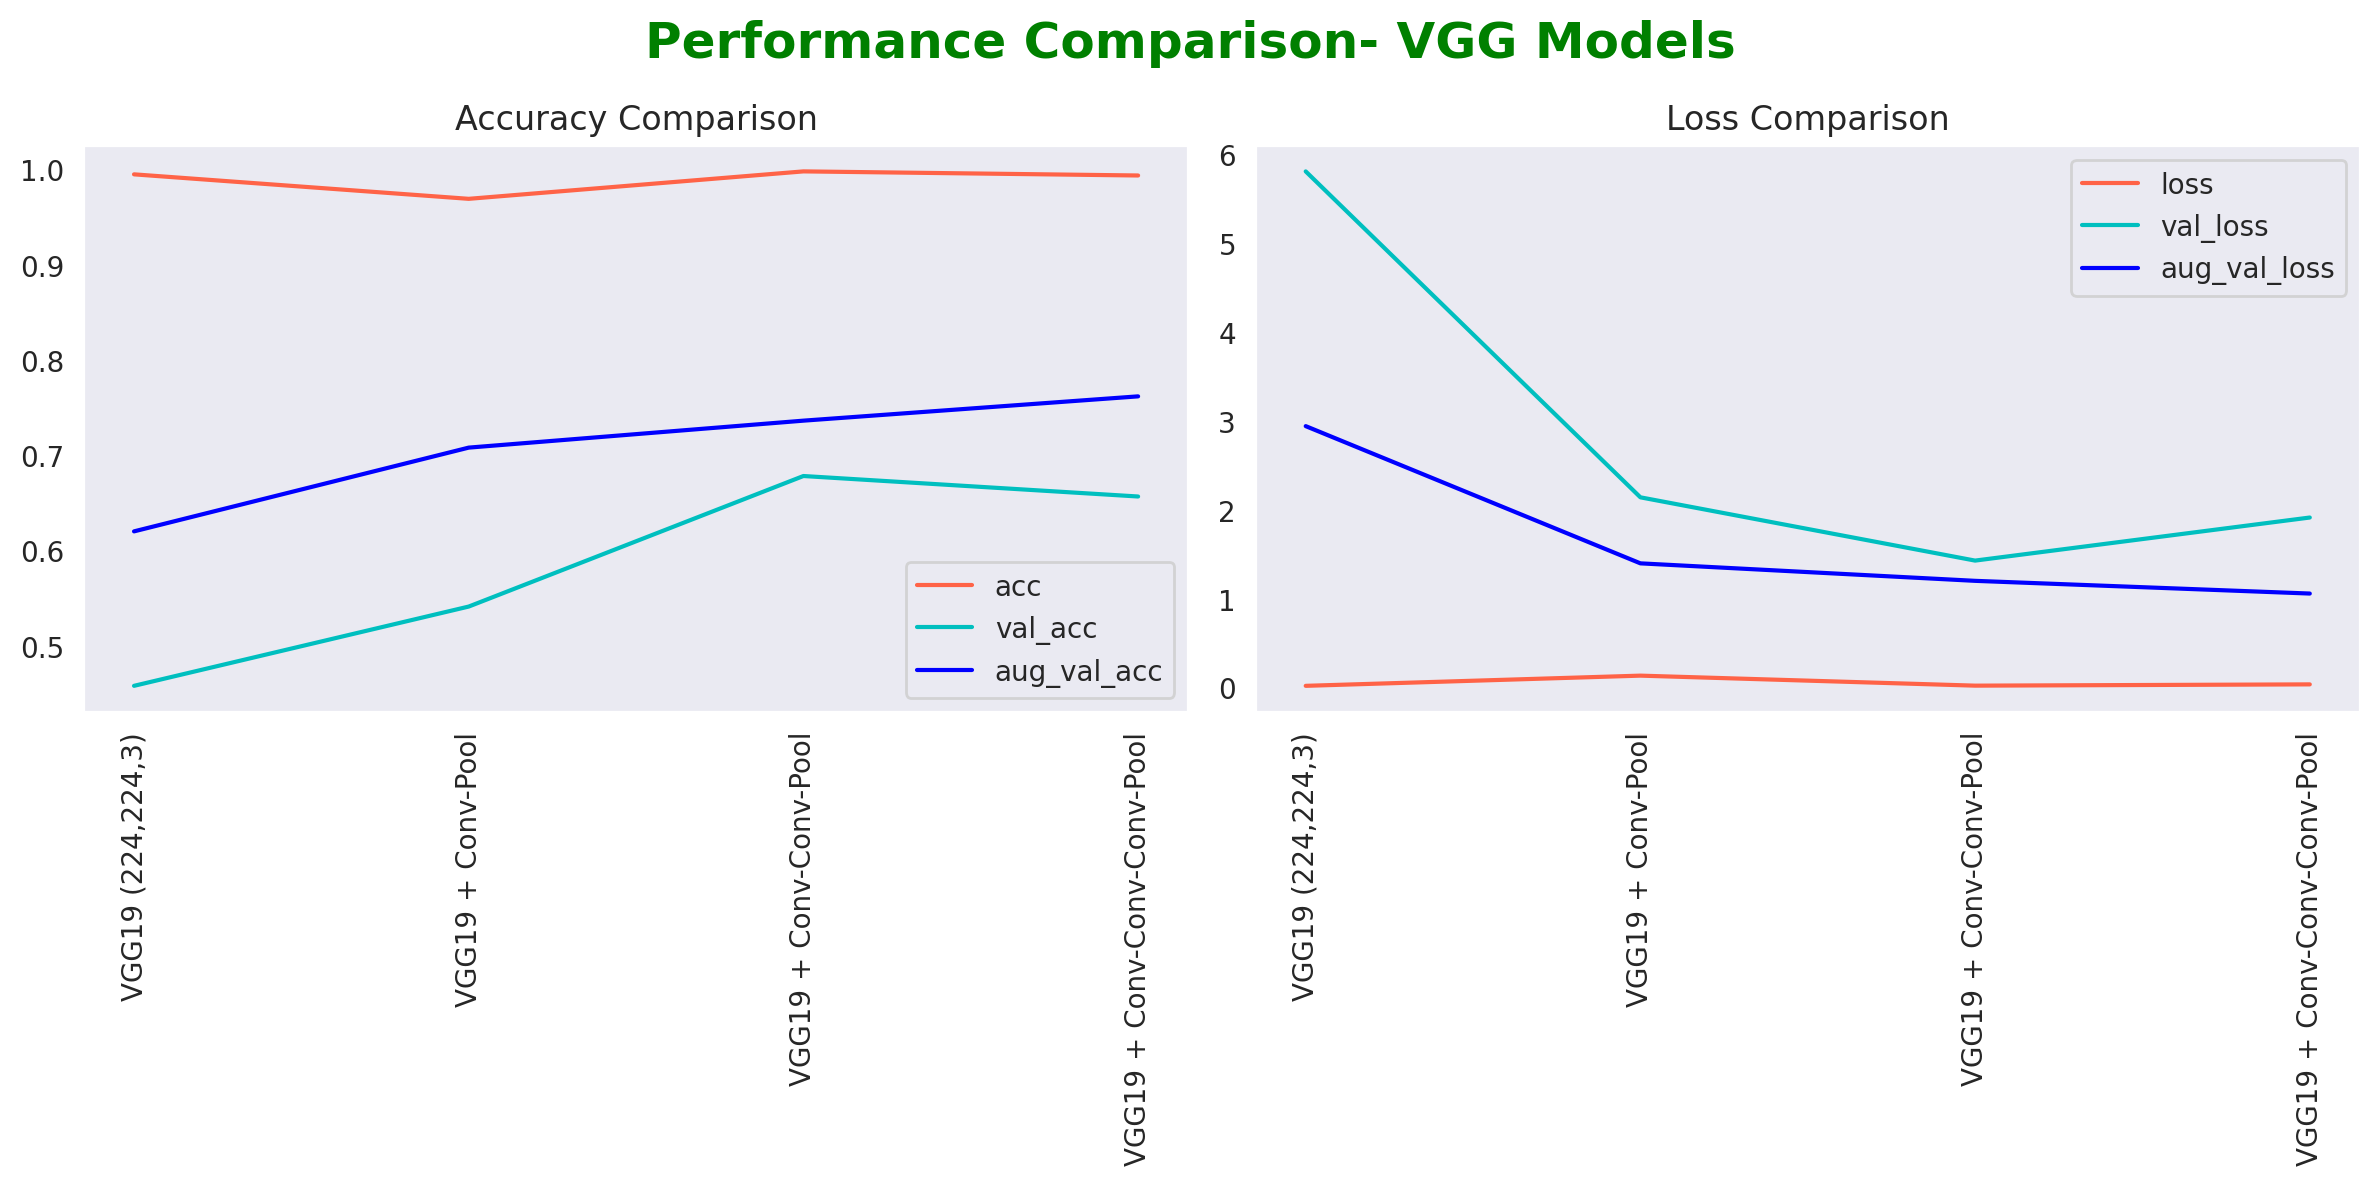

In [ ]:
plt.subplots(1,2, figsize=(12, 6))

plt.subplot(121)
plt.plot(performance_df.loc['acc',:], color='tomato', label='acc')
plt.plot(performance_df.loc['val_acc',:], color='c', label='val_acc')
plt.plot(aug_performance_df.loc['val_acc',:], color='b', label='aug_val_acc')
plt.xticks(rotation=90)
plt.legend()
plt.title("Accuracy Comparison")

plt.subplot(122)
plt.plot(performance_df.loc['loss',:], color='tomato', label='loss')
plt.plot(performance_df.loc['val_loss',:], color='c', label='val_loss')
plt.plot(aug_performance_df.loc['val_loss',:], color='b', label='aug_val_loss')
plt.xticks(rotation=90)
plt.legend()
plt.title("Loss Comparison")

plt.suptitle("Performance Comparison- VGG Models", weight='black', fontsize=18, color='green')
plt.tight_layout()
plt.show()

## Dog Breeds Classification with Data Augumentation:

- Images from each dog breed are upsampled by  augumenting using `imgaug` such that each breed contain 200 images.
----------------------------------------------------------------------------------------------------------------------------------
Results:
1. VGG16 (Default Image Size) + Classification Head
    - Accuracy: **did not trained** (w/o aug: 0.0.6014)
    - Validation Accuracy: **did not trained** (w/o aug: 0.2231)
2. VGG19 (Default Image Size) with augumentation
    - Accuracy: **0.9995**  
    - Validation Accuracy: **0.6200**
3. VGG19 (Image Size: 380,380, 3) + Conv-Pool Chunk with augumentation
    - Accuracy: **0.9982**
    - Validation Accuracy: **0.7079**
4. VGG19 (Image Size: 380,380, 3) + Conv-Conv-Pool Chunk with augumentation
    - Accuracy: **0.9806**
    - Validation Accuracy: **0.7362**
5. VGG19 (Image Size: 380,380, 3) + Conv-Conv-Conv-Pool Chunk with augumentation
    - Accuracy: **0.9917**
    - Validation Accuracy: **0.7617**

## Observations:

- Augumented dataset contain total 24,000 images.

- The VGG19 validation accuracy **increased 15%**, and the validation loss **decreased by 50%** when data augmentation was used for oversampling, compared to the model with class imbalance.

- Maximum validation accuracy achieved is **76%** which is **9%** more than the accuracy achieved without augumentation.

- **VGG19 took 50 epochs to achieve the highest validation accuracy. In contrast, VGG19 with augmentation attained the highest validation accuracy in just 20 epochs.**

- Certainly, the impact of data augmentation is significant.

### Challenges
- **overfitting** is still a prominent issue.


